# Datamining

In [1]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
#import pickle
#from yellowbrick import __version__ as yb_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [2]:
df_bitm = pd.read_csv(r'data/BITM_Cancer_dataset.csv', sep='\t', header=None)
print('nr of entries: ', len(df_bitm))

df_bitm.head()

nr of entries:  100


,0,1,2,3,4,5,6,7,8,9,...,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835
0,Array.129,HER2+,0,0,0,0,0,0,0,0,...,2,2,2,2,0,1,1,1,1,1
1,Array.34,HR+,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,Array.67,HR+,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,Array.24,Triple Neg,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,Array.22,Triple Neg,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


(32, 36, 32)


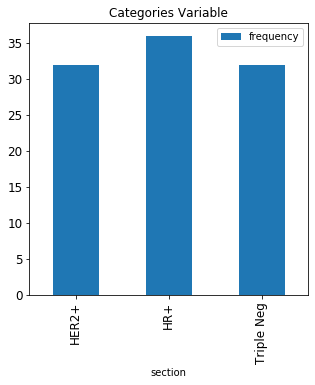

In [10]:
from collections import Counter

labels, values = zip(*Counter(df_bitm[1]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

### Import important modules

In [20]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
import numpy as np

## Feature Reduction

In [17]:
X = df_bitm[df_bitm.columns[2:]]
y = df_bitm[df_bitm.columns[1]]


## Double Cross Validation

In [35]:
# large folds -> to ensure enough training & validation data
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pickle

SEED = 26062019

X = df_bitm[df_bitm.columns[2:]]
y = df_bitm[df_bitm.columns[1]]

hyperparam = [0.1, 1, 10, 100]
kfold_outer = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)

## later omringen met kfold_outer
for i, (train, valid) in enumerate(kfold_outer.split(X, y)):
    # reset
    old_f1 = 0
    param = 0
    kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)
    best_model = ''
    X_train, y_train, X_valid, y_valid = X.iloc[train], y.iloc[train], X.iloc[valid], y.iloc[valid]
    for i, (in_train, in_test) in enumerate(kfold_inner.split(X_train, y_train)):
        clf = SVC(C=hyperparam[i])
        clf.fit(X_train.iloc[in_train], y_train.iloc[in_train])
        y_pred = clf.predict(X_train.iloc[in_test])
        #print(clf.coef_[:10])
        f1 = f1_score(y_train.iloc[in_test], y_pred, average='macro')
        print('Iteration:', str(i), 'F1:', str(f1), 'C: ', str(hyperparam[i]))
        if f1 > old_f1:
            pickle.dump(clf, open('models/optimal_model.sav', 'wb'))
            old_f1 = f1
            param = hyperparam[i]
        # if performance > old_performance # macro F1
        # return model
    # Load best model
    print('F1-Inner:', old_f1, 'C: ', param)
    optimal_model = pickle.load(open('models/optimal_model.sav', 'rb'))
    final_y_pred = optimal_model.predict(X_valid)
    final_f1 = f1_score(y_valid, final_y_pred, average='macro')
    print('F1-final:', final_f1)
    

C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in

Iteration: 0 F1: 0.17777777777777778 C:  0.1
Iteration: 1 F1: 0.30501089324618735 C:  1
Iteration: 2 F1: 0.6174089068825911 C:  10
F1-Inner: 0.6174089068825911 C:  10
F1-final: 0.6874762808349146
Iteration: 0 F1: 0.17777777777777778 C:  0.1
Iteration: 1 F1: 0.30069930069930073 C:  1
Iteration: 2 F1: 0.8167832167832167 C:  10
F1-Inner: 0.8167832167832167 C:  10
F1-final: 0.6851851851851852
Iteration: 0 F1: 0.16666666666666666 C:  0.1
Iteration: 1 F1: 0.43469785575048725 C:  1
Iteration: 2 F1: 0.5423280423280423 C:  10
F1-Inner: 0.5423280423280423 C:  10
F1-final: 0.65


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 

In [ ]:
# Hyperparameter tuning

p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}